# CalPred model

# Introduction
Polygenic scores (PGS) have emerged as the tool of choice for genomic prediction in personalized medicine. A critical barrier in PGS use is their **context-specific accuracy** – their accuracy varies across genetic ancestry, age, sex, socioeconomic status and other factors. Such context-specific accuracy suggests that two individuals can have the same point predictions with different precisions. We propose an approach (CalPred) to incorporate context-specificity into trait prediction intervals that are allowed to vary across contexts. As an example, consider the case of two individuals with the same PGS-based predictions for low-density lipoprotein cholesterol (LDL) of 120 mg/dL. If the two individuals have different contexts (e.g., sex) that are known to impact PGS accuracy (e.g., $R^2$=0.1 in men vs. 0.2 in women), their prediction intervals will also vary (e.g., 120 ± 40 mg/dL vs. 120 ± 10 mg/dL). In this example the second individual is more likely to meet a decision criterion of LDL>100 mg/dL for clinical intervention.

We model such prediction intervals using the following approaches by relating each individual's prediction variance to their contexts.
$$ 
y_i \sim \mathcal{N} (\mu(\mathbf{c}_i ),\sigma^2 (\mathbf{c}_i )),i=1,…,N
$$
where 
$$
\mu(\mathbf{c}_i)=\mathbf{c}_i^\top \boldsymbol{\beta}_\mu, \sigma^2 (\mathbf{c}_i )=\exp⁡(\mathbf{c}_i^\top\boldsymbol{\beta}_\sigma).
$$

# Simulate phenotype with context-specific accuracy
We simulate variable prediction accuracy across genetic ancestry continuum, age and sex. For simplicity, we assume that the point predictions are given, denoted as $\hat{y} \sim \mathcal{N}(0, 1)$, and we simulate phenotypes $y$ with:

$$
y \sim \mathcal{N}\left(
\hat{y}, 
\exp(\beta_{\sigma,0} + 
\beta_{\sigma, \text{ancestry}} \times \text{ancestry} +
\beta_{\sigma, \text{age}} \times \text{age} +
\beta_{\sigma, \text{sex}} \times \text{sex}
) 
\right)
$$
First, we set $\beta_{\sigma,0} = \log (0.7 / 0.3)$ such that the baseline $R^2 = 0.3$ to control the baseline accuracy. Then we set $\beta_{\sigma, \text{ancestry}} = 0.15, \beta_{\sigma, \text{age}} = 0.25, \beta_{\sigma, \text{sex}} = 0.2$ (these effects are standardized with regard to each standard deviation of context.

In [357]:
source("calpred.R")
library(ggplot2); theme_set(theme_bw())
library(dplyr)
library(patchwork)

options(repr.plot.res = 200)

In [358]:
n_indiv <- 20000

set.seed(1234)

# simulate contexts
data <- data.frame(
    yhat = rnorm(n_indiv),
    intercept = 1,
    ancestry = runif(n_indiv),
    age = as.integer(runif(n_indiv, min=20, max=80)),
    sex = rbinom(n_indiv, size=1, prob = 0.5)
)
data[, "ancestry_q"] <- cut_number(data[, "ancestry"], 5)
data[, "age_q"] <- cut_number(data[, "age"], 5)
data[, c('ancestry', 'age', 'sex')] <- scale(data[, c('ancestry', 'age', 'sex')])

In [359]:
y_mean <- data[, 'yhat']

sd_mat <- as.matrix(data[, c("intercept", "ancestry", "age", "sex")])
# determine coefficients

sd_coef <- c(
    intercept = log(7/3),
    ancestry = 0.25,
    age = 0.15,
    sex = 0.2
)
y_sd <- sqrt(exp(sd_mat %*% sd_coef))
y <- rnorm(n = n_indiv, mean = y_mean, sd = y_sd)

# Visualizing context-specific accuracy

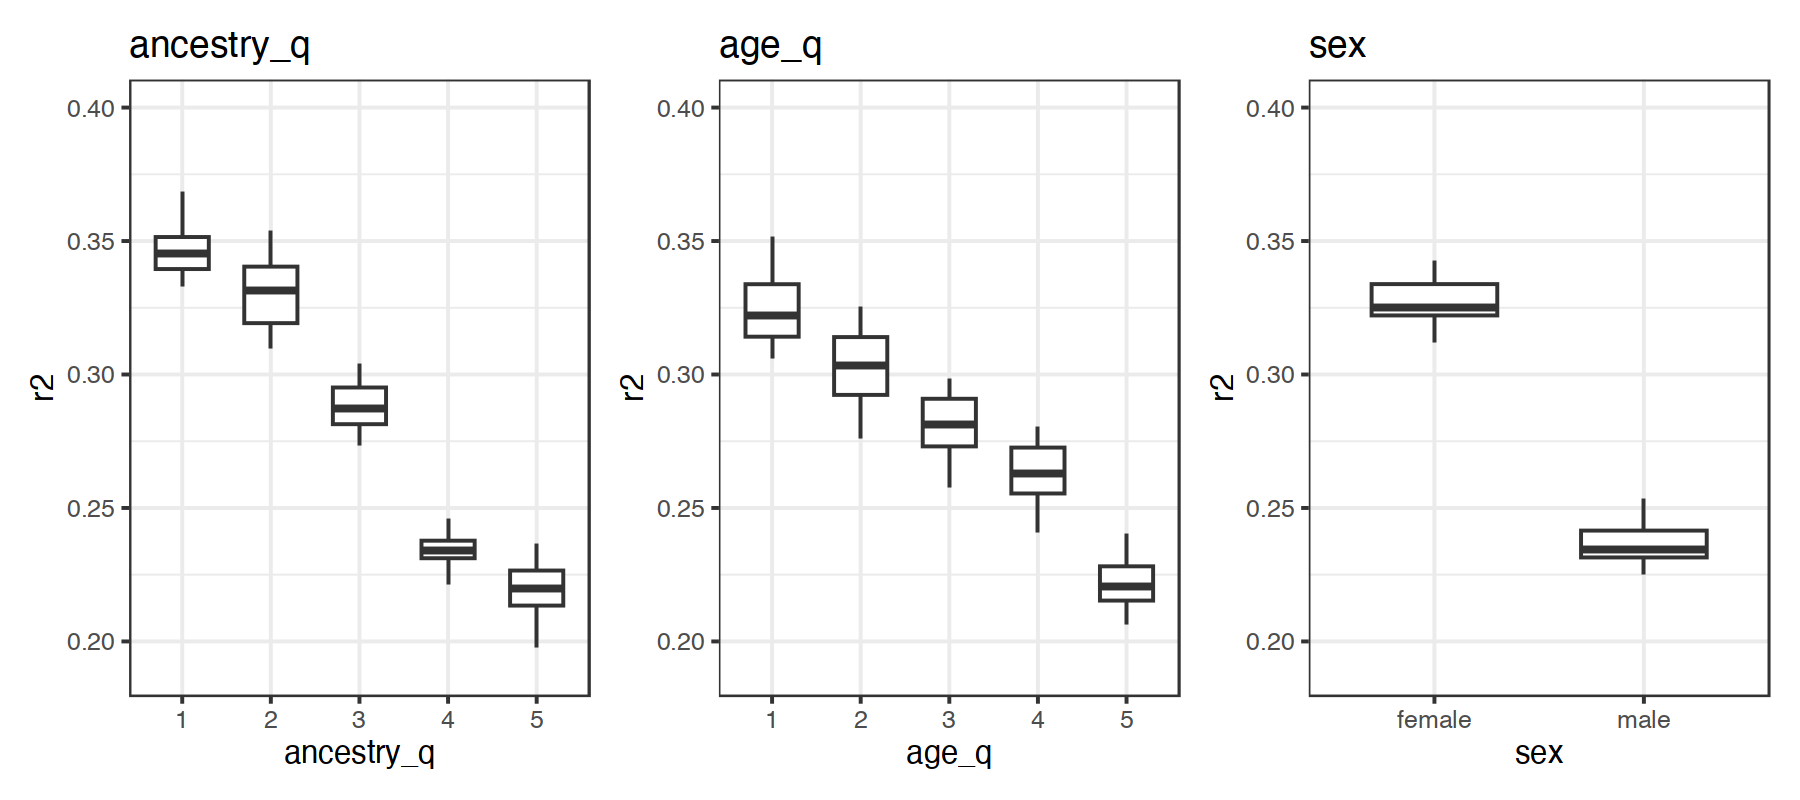

In [360]:
# TODO wrap plot into function modules

plot_list <- list()

for (context in c("ancestry_q", "age_q", "sex")) {
    stats <- compute_stats(y=y, pred=y_mean, group=data[, context], n_bootstrap=20)
    bs_df <- stats$bootstrap_stats
    p <- ggplot(bs_df, aes(x=as.factor(group),y=r2)) +
          geom_boxplot(size=1, width = 0.6, linewidth=0.5, outlier.shape = NA) +
          labs(title = context, x=context) +
          ylim(0.19, 0.4)
    plot_list[[context]] <- p
}

plot_list[["ancestry_q"]] <- plot_list[["ancestry_q"]] + scale_x_discrete(labels = c("1", "2", "3", "4", "5"))
plot_list[["age_q"]] <- plot_list[["age_q"]] + scale_x_discrete(labels = c("1", "2", "3", "4", "5"))
plot_list[["sex"]] <- plot_list[["sex"]] + scale_x_discrete(labels = c("female", "male"))

options(repr.plot.width = 9, repr.plot.height = 4)
wrap_plots(plotlist = plot_list, ncol = 3)

# Fit CalPred model

In [366]:
mean_mat <- as.matrix(data[, 'yhat', drop=FALSE])
sd_mat <- as.matrix(data[, c("intercept", "ancestry", "age", "sex")])

fit <- train(mean_mat=mean_mat, sd_mat=sd_mat, y=y)
pred <- predict(mean_mat=mean_mat, sd_mat=sd_mat, mean_coef=fit$mean_coef, sd_coef=fit$sd_coef)

# Quality of parameter fit
We first check the quality of parameter fit and observe a high consistency between fitted coefficients `fit$sd_coef` and true coefficients `sd_coef`  

In [367]:
fit

$mean_coef
     yhat 
0.9841375 

$mean_se
      yhat 
0.01051455 

$sd_coef
intercept  ancestry       age       sex 
0.8475305 0.2447044 0.1655629 0.1948826 

$sd_se
 intercept   ancestry        age        sex 
0.01000025 0.01000105 0.01000103 0.01000109

In [368]:
sd_coef

intercept  ancestry       age       sex 
0.8472979 0.2500000 0.1500000 0.2000000

# Check for calibration

In [369]:
# mean_mat <- as.matrix(data[, 'yhat', drop=FALSE])
# sd_mat <- as.matrix(data[, c("intercept"), drop=FALSE])

# fit <- train(mean_mat=mean_mat, sd_mat=sd_mat, y=y)
# pred <- predict(mean_mat=mean_mat, sd_mat=sd_mat, mean_coef=fit$mean_coef, sd_coef=fit$sd_coef)

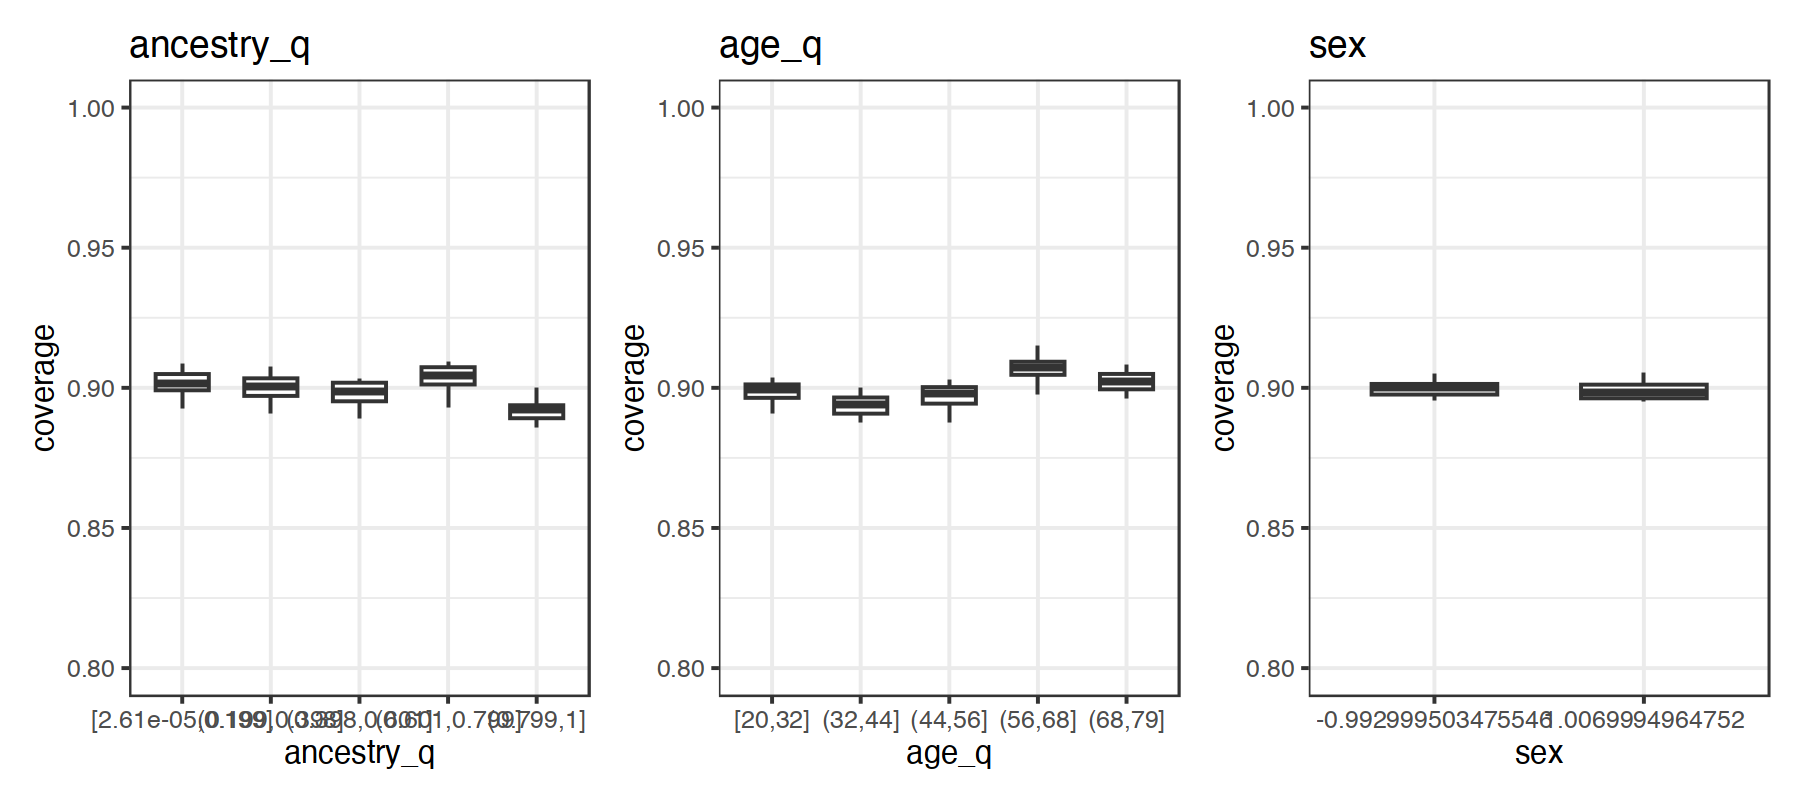

In [370]:
plot_list <- list()

for (context in c("ancestry_q", "age_q", "sex")) {
    stats <- compute_stats(y=y, pred=y_mean, predsd=pred$sd, group=data[, context], n_bootstrap=20)
    bs_df <- stats$bootstrap_stats
    p <- ggplot(bs_df, aes(x=as.factor(group), y=coverage)) +
          geom_boxplot(size=1, width = 0.6, linewidth=0.5, outlier.shape = NA) +
          labs(title = context, x=context) +
          ylim(0.8, 1.0) + 
    plot_list[[context]] <- p
}
wrap_plots(plotlist = plot_list, ncol = 3)

# Example analysis for individual-level trait
Next we present an example workflow for analyzing trait.

In [371]:
normalize_table <- function(x) {
    return (data.frame(
        q = qnorm((rank(x) - 0.5) / length(x)),
        x = x
    ))
}